In [21]:
import numpy as np
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
import matplotlib.pyplot as plt
import imageio
import mat73
import scipy.io as sio

In [25]:
data = mat73.loadmat("/mnt/c/Users/ankku/Documents/IITB Lectures and Study Material/Sem6/CS736/assignmentImageDenoising/data/assignmentImageDenoising_chestCT.mat")
data

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/mnt/c/Users/ankku/Documents/IITB Lectures and Study Material/Sem6/CS736/assignmentImageDenoising/data/assignmentImageDenoising_chestCT.mat', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [26]:
image = data['imageChestCT']
image

NameError: name 'data' is not defined

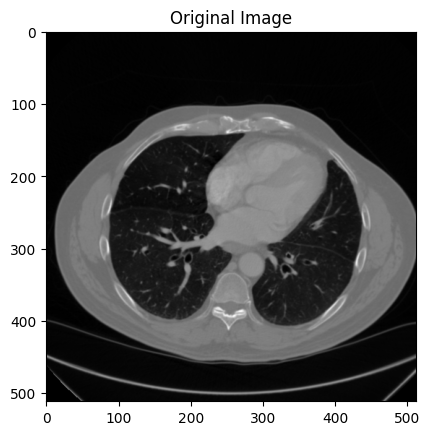

In [18]:
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.show()

In [19]:
def learn_dictionary(image, patch_size=(8,8), K=64, p=2, lambda_=0.1, num_iter=10, subset_size=1000, variance_percentile=50, random_state=None):
    # Extract patches
    patches = extract_patches_2d(image, patch_size)
    patches = patches.reshape(len(patches), -1)

    # Select subset based on variance
    variances = np.var(patches, axis=1)
    threshold = np.percentile(variances, variance_percentile)
    selected_indices = np.where(variances > threshold)[0]
    selected_patches = patches[selected_indices]
    if subset_size < len(selected_patches):
        selected_indices = np.random.choice(len(selected_patches), subset_size, replace=False)
        selected_patches = selected_patches[selected_indices]
    X = selected_patches.T

    # Initialize dictionary
    if random_state is not None:
        np.random.seed(random_state)
    np.random.shuffle(selected_patches)
    D = selected_patches[:K].T
    D = D / np.maximum(np.linalg.norm(D, axis=0), 1)
    D_init = D.copy()

    # Training loop
    objectives = []
    for iter in range(num_iter):
        # Sparse coding with IRLS
        R = np.zeros((K, X.shape[1]))
        for i in range(X.shape[1]):
            xi = X[:, i]
            ri = irls(xi, D, p, lambda_)
            R[:, i] = ri

        # Dictionary update with projected gradient
        grad = -2 * (X - D @ R) @ R.T
        L = np.linalg.norm(R @ R.T, ord=2)
        lr = 1 / (2 * L + 1e-8)
        D -= lr * grad
        D = D / np.maximum(np.linalg.norm(D, axis=0), 1)

        # Compute objective
        data_fidelity = np.linalg.norm(X - D @ R, 'fro')**2
        regularization = lambda_ * np.sum(np.linalg.norm(R, ord=p, axis=0)**p)
        objectives.append(data_fidelity + regularization)

    return D_init, D, objectives, R

In [20]:
def irls(xi, D, p, lambda_, max_iter=10, eps=1e-6):
    K = D.shape[1]
    ri = np.zeros(K)
    for _ in range(max_iter):
        abs_ri = np.abs(ri)
        abs_ri[abs_ri < eps] = eps
        weights = (lambda_ * p / 2) * (abs_ri ** (p - 2))
        A = D.T @ D + np.diag(weights)
        b = D.T @ xi
        ri_new = np.linalg.lstsq(A, b, rcond=None)[0]
        if np.linalg.norm(ri_new - ri) < 1e-5:
            break
        ri = ri_new
    return ri

In [21]:
image = data['imageChestCT']
p_values = [2, 1.6, 1.2, 0.8]
results = {}
random_seed = 42

In [22]:
for p in p_values:
    D_init, D, objectives, R = learn_dictionary(image, p=p, lambda_=0.1, num_iter=5, random_state=random_seed)
    results[p] = {'D_init': D_init, 'D': D, 'objectives': objectives, 'R': R}

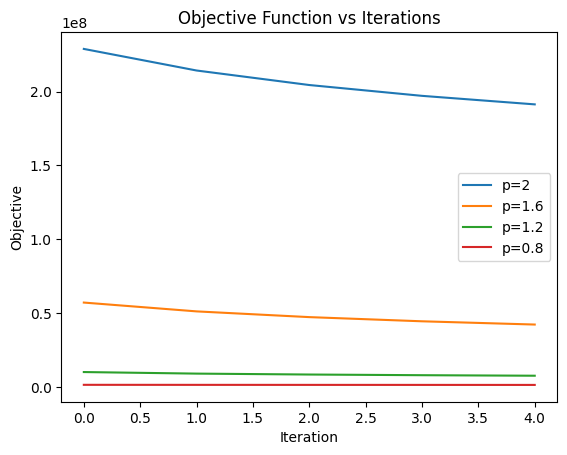

In [23]:
plt.figure()
for p in p_values:
    plt.plot(results[p]['objectives'], label=f'p={p}')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Objective')
plt.title('Objective Function vs Iterations')
plt.show()

In [24]:
def plot_atoms(D, title):
    plt.figure(figsize=(10,10))
    for i in range(64):
        plt.subplot(8,8,i+1)
        plt.imshow(D[:,i].reshape(8,8), cmap='gray', interpolation='nearest')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

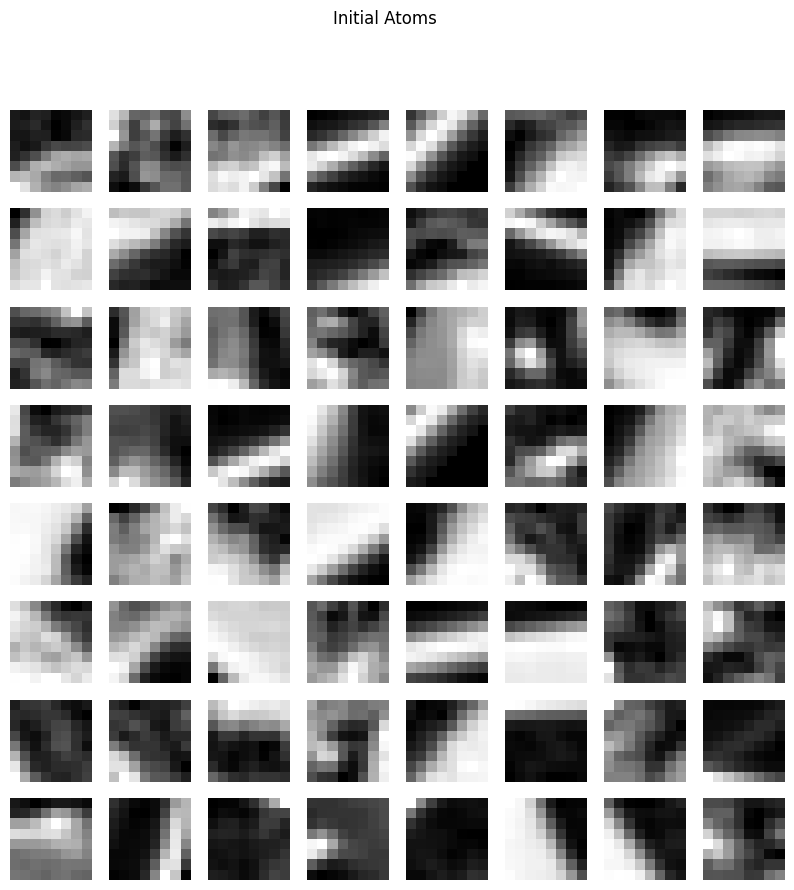

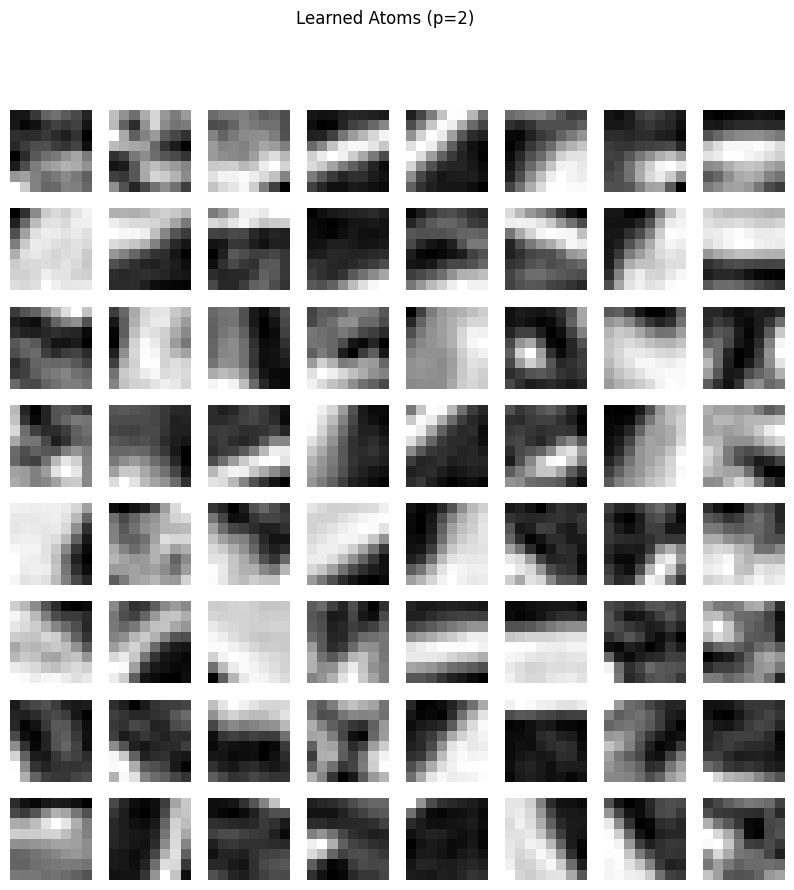

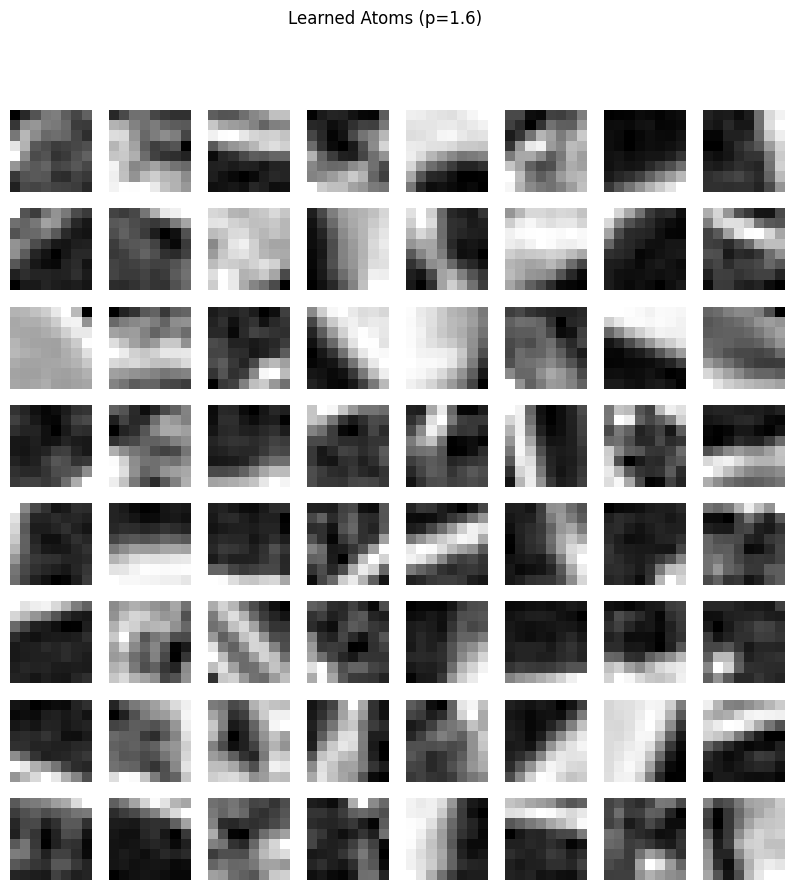

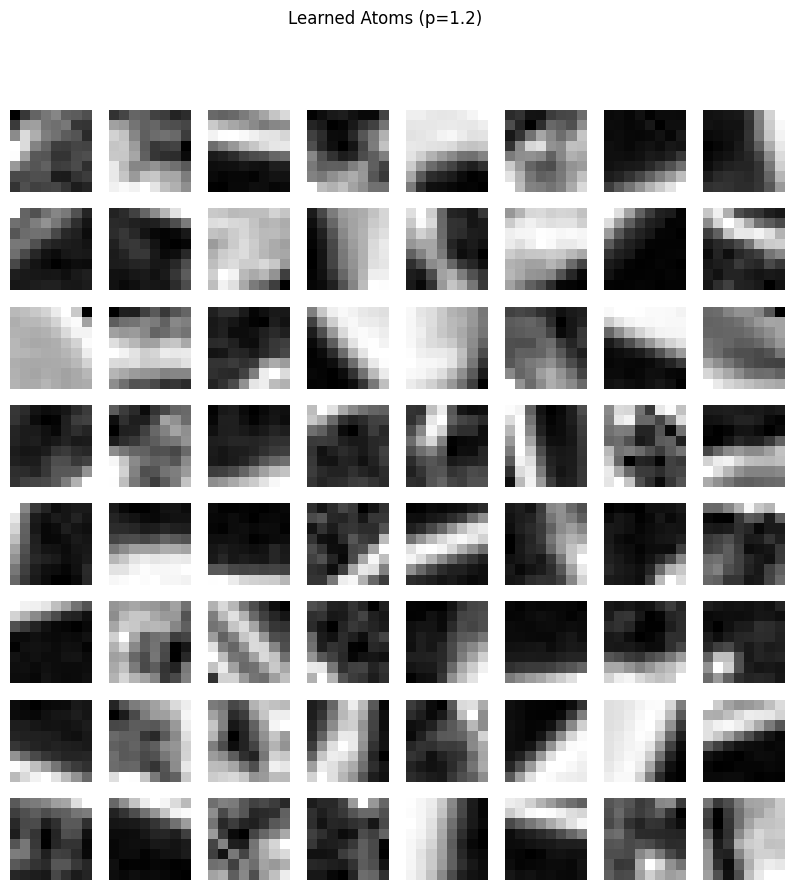

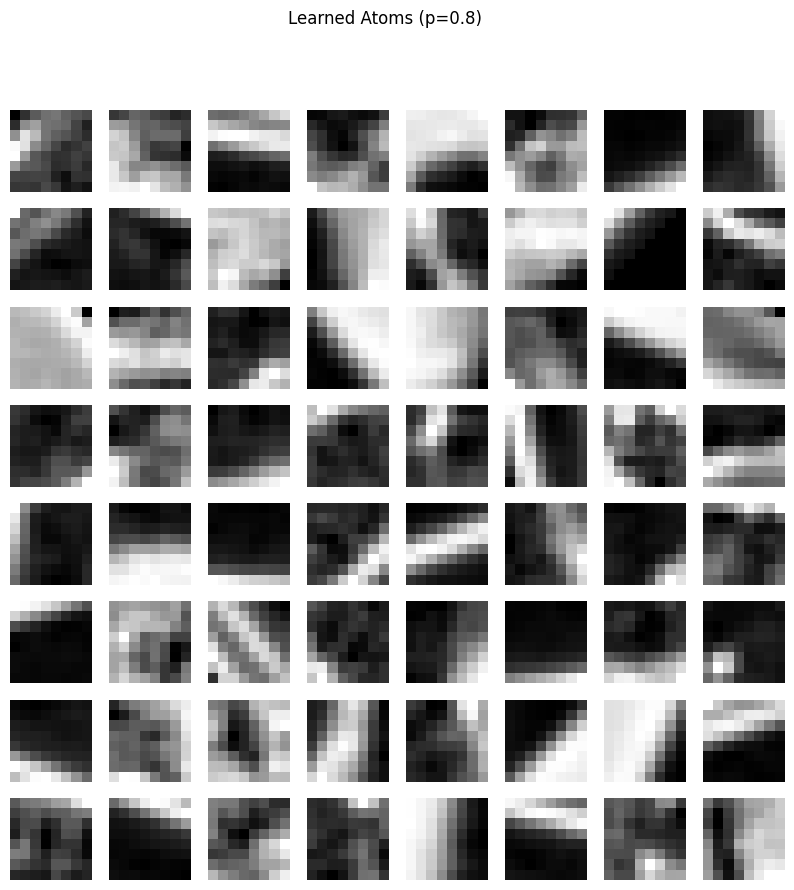

In [25]:
plot_atoms(results[2]['D_init'], 'Initial Atoms')
for p in p_values:
    plot_atoms(results[p]['D'], f'Learned Atoms (p={p})')

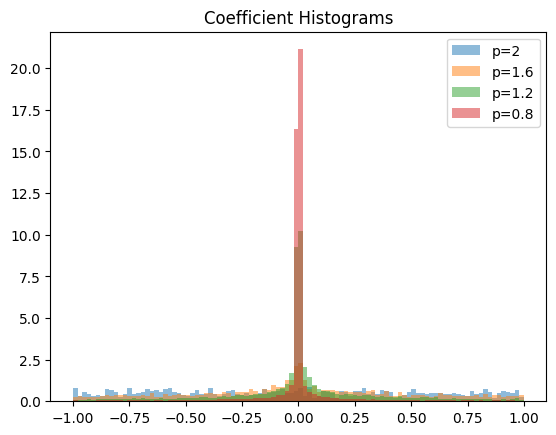

In [26]:
plt.figure()
for p in p_values:
    coefficients = results[p]['R'].flatten()
    plt.hist(coefficients, bins=100, alpha=0.5, label=f'p={p}', density=True, range=(-1,1))
plt.legend()
plt.title('Coefficient Histograms')
plt.show()

In [27]:
def irls_batch(X, D, p, lambda_, max_iter=10):
    R = np.zeros((D.shape[1], X.shape[1]))  
    
    for _ in range(max_iter):
        residual = X - D @ R  
        gradient = D.T @ residual  

        R = R - 0.1 * gradient  

        R = np.sign(R) * np.maximum(np.abs(R) - lambda_ * np.power(np.abs(R)+1e-10, p - 1), 1e-10)

    return R

In [28]:
def denoise(noisy_image, D, p, lambda_, mu, patch_size=(8,8), num_iter=5):
    image_height, image_width = noisy_image.shape
    X = noisy_image.copy()
    objective_values = []

    for iter in range(num_iter):
        print(f"Iteration {iter+1}/{num_iter}")

        patches = extract_patches_2d(X, patch_size)
        patches = patches.reshape(len(patches), -1).T  


        R = irls_batch(patches, D, p, lambda_)  


        recon_patches = (D @ R).T.reshape(-1, *patch_size)  
        X_recon = reconstruct_from_patches_2d(recon_patches, (image_height, image_width))

        X = (X_recon + mu * noisy_image) / (1 + mu)

        residual = noisy_image - X
        objective = np.linalg.norm(residual, 'fro')**2 + lambda_ * np.sum(np.abs(R)**p)
        objective_values.append(objective)

    plt.figure()
    plt.plot(range(1, num_iter + 1), objective_values, marker='o', linestyle='-')
    plt.xlabel('Iterations')
    plt.ylabel('Objective Function')
    plt.title('Objective Function vs Iterations (Denoising)')
    plt.grid()
    plt.show()

    return X

In [29]:
image_array = image
noise_std = 0.1 * (image_array.max() - image_array.min())
noisy = image_array + np.random.normal(0, noise_std, image_array.shape)
noisy = np.clip(noisy, 0, 255)


Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10


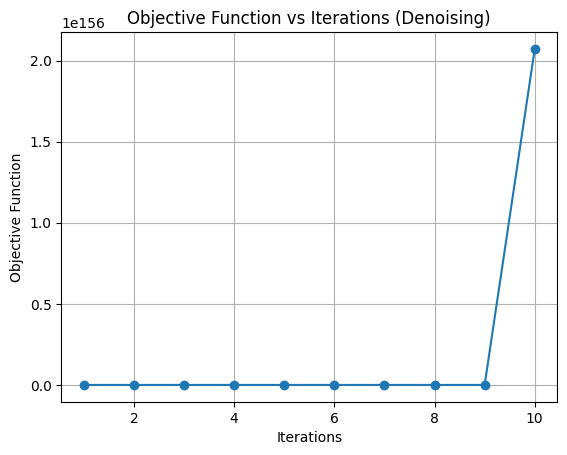

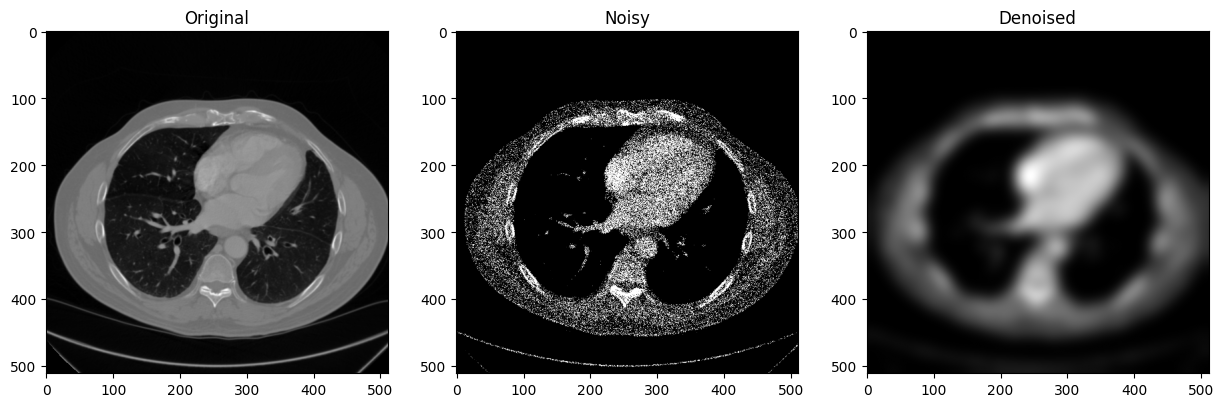

In [30]:
D_p08 = results[0.8]['D']
denoised = denoise(noisy, D_p08, p=0.8, lambda_=0.01, mu=3.0, num_iter=10)

plt.figure(figsize=(15,5))
plt.subplot(131), plt.imshow(image_array, cmap='gray'), plt.title('Original')
plt.subplot(132), plt.imshow(noisy, cmap='gray'), plt.title('Noisy')
plt.subplot(133), plt.imshow(denoised, cmap='gray'), plt.title('Denoised')
plt.show()